# Plotting the CTH Results

In [1]:
%pylab inline
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.ticker as mtick
from hits import CyDetHits, CTHHits, CDCHits

## Import Data

In [3]:
# Test on signal or background data files
test_sig = True

In [4]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
cdc_sig_file = file_base + "after_sum_hit_cth.root"
cth_sig_file = cdc_sig_file

In [5]:
if test_sig:
    hits_cydet = CyDetHits(cdc_sig_file, 
                       tree="CDCHitTree",
                       branches=["MCPos.fP.fX", "MCPos.fP.fY","MCPos.fP.fZ", "MCPos.fE"])
    hits_cth = CTHHits(cth_sig_file, 
                       tree="CTHHitTree",
                       branches=["MCPos.fP.fX","MCPos.fP.fY","MCPos.fP.fZ"])
else:
    hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])
    hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])

In [6]:
hits = CDCHits(hits_cydet, hits_cth)

from cylinder import CyDet
geom = CyDet()
n_events = hits_cth.n_events
print "Start Events: {}".format(hits.cth.n_events)

Start Events: 4021


## Apply All Cuts

In [7]:
# Define cuts to use
n_hits_cut = False
layer_cut = False
timing_cut = False
use_cth_cut = True

In [8]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1100, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

In [9]:
hits.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CyDet Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fMCPos.fE
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [10]:
# Filter for CTH in time window.  Get the time
trigger_events = []
for evt in range(hits.n_events):
    sig_hits = hits.cth.get_signal_hits(evt)
    evt_index = np.unique(hits.cth.get_measurement(evt, "CTHHit.fEventNumber"))[0]
    if len(sig_hits) != 0:
        trigger_events.append(evt_index)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 3798


In [11]:
# Filter for max layer is five
max_layer = []
for evt in range(hits.n_events):
    these_layers = hits.cydet.geom.point_layers[hits.cydet.get_sig_wires(evt)]
    if len(hits.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Number that pass layer cut: {}".format(len(good_max_layer))

Number that pass layer cut: 3303


In [12]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(hits.cydet.get_signal_hits(evt)) 
                         for evt in range(hits.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits > 30)[0]
print "Number that pass n hits cut: {}".format(len(good_n_hits))

Number that pass n hits cut: 3480


In [13]:
# Apply quality and CTH cuts
print "Start Events: {}".format(hits.n_events)
if use_cth_cut:
    hits.trim_events(trigger_events)
    print "After CTH Trigger {}".format(hits.n_events)
if layer_cut:
    hits.trim_events(good_max_layer)
    print "After Layer Cut Trigger {}".format(hits.n_events)
if n_hits_cut:
    hits.trim_events(good_events)
    print "Afterb N Hits Cut Trigger {}".format(hits.n_events)

Start Events: 4021
After CTH Trigger 3798


In [14]:
print hits.cth.all_branches

['CTHHit.fMCPos.fP.fX', 'CTHHit.fMCPos.fP.fY', 'CTHHit.fMCPos.fP.fZ', 'CTHHit.fIsSig', 'CTHHit.fEventNumber', 'CTHHit.fhits_index', 'CTHHit.fevent_index', 'CTHHit.fTrigTime', 'CTHHit.fvol_id', 'CTHHit.fCharge', 'CTHHit.fMCPos.fE']


# CTH Alignment

## Import the ICEDUST and Local Coordinate Data

In [15]:
from cylinder import CTH

In [16]:
test_geom = CTH()

In [17]:
coordinate_file = file_base + "scintillator_positions.txt"
coordinate_file = file_base + "cherenkov_positions.txt"

In [18]:
from collections import OrderedDict

In [19]:
crys_to_coords = np.ndarray((64,2,3))

In [20]:
with open(coordinate_file) as coords:
    for line in coords.readlines()[:64]:
        split_line = line[:-2].split(" ")
        crystal = int(split_line[0].split("_")[-1][:-1]) - 64
        all_coords = np.array(split_line[1:7], dtype=float).reshape(2,-1)
        crys_to_coords[crystal] = all_coords

In [21]:
angles = np.arctan2(crys_to_coords[:,1,0],crys_to_coords[:,1,1])[:-5] - np.pi/2.
radial = np.ones_like(angles) * np.average(np.sqrt(np.square(crys_to_coords[:,1,0]) + \
                                                   np.square(crys_to_coords[:,1,1])))

In [22]:
print radial

[ 44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199  44.78000199
  44.78000199  44.78000199  44.78000199  44.78000199]


/home/elg112/development/miniconda2/envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


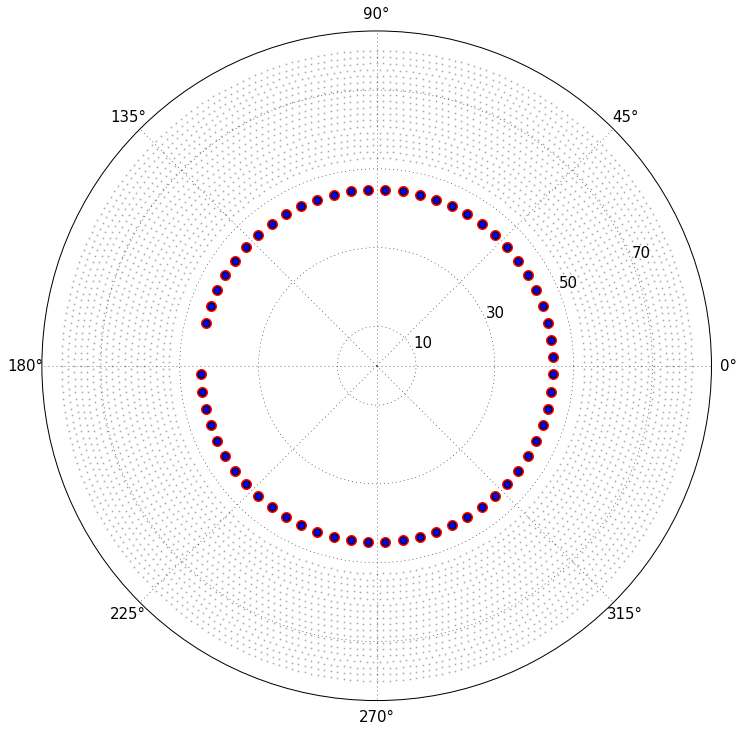

In [23]:
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
plt.scatter(test_geom.get_points_rhos_and_phis()[1][128:190] ,
            test_geom.get_points_rhos_and_phis()[0][128:190],s=100, color="red")
plt.scatter(crys_to_coords[:,1,0][:-2],crys_to_coords[:,1,1][:-2], s=50, transform=gca().transData._b)

In [24]:
print (angles/np.pi * 180) 
print (angles/np.pi * 180) % 360
print test_geom.get_points_rhos_and_phis()[1][:64]/np.pi * 180

[-182.8123243  -188.43738284 -194.06231063 -199.68749419 -205.31271499
 -210.93742466 -216.56286463 -222.18807574 -227.81281017 -233.43782478
 -239.06294854 -244.68732721 -250.31235108 -255.93824777 -261.56322425
 -267.18780999   87.18653204   81.5619586    75.93700662   70.31235108
   64.68732721   59.06185108   53.43672086   47.8117762    42.18712167
   36.56199967   30.93731492   25.31205227   19.68694268   14.06218651
    8.43706854    2.81218373   -2.81282271   -8.4376887   -14.06280709
  -19.68754502  -25.31263059  -30.93786365  -36.56251352  -42.18750088
  -47.8121199   -53.43710196  -59.0621142   -64.68749133  -70.31248039
  -75.93713098  -81.56201493  -87.18655088  -92.81217117  -98.43671943
 -104.06165896 -109.68751961 -115.31250867 -120.93685412 -126.56202278
 -132.18701798 -137.81259392 -143.43692982 -149.06235584]
[ 177.1876757   171.56261716  165.93768937  160.31250581  154.68728501
  149.06257534  143.43713537  137.81192426  132.18718983  126.56217522
  120.93705146  115

In [25]:
this_crys = 11
print crys_to_coords[this_crys,1,0] - test_geom.get_points_xs_and_ys()[0][this_crys]
print crys_to_coords[this_crys,1,1] - test_geom.get_points_xs_and_ys()[1][this_crys]

-38.2919170838
0.000140546067797


In [26]:
for crys in range(64):
    print crys
    print crys_to_coords[crys,1,:2] - \
        np.hstack([test_geom.get_points_xs_and_ys()[0][crys], 
                   test_geom.get_points_xs_and_ys()[1][crys]])

0
[ -8.94520605e+01   1.40456382e-04]
1
[ -8.85903241e+01   1.40646111e-04]
2
[ -8.68759995e+01   1.52456068e-04]
3
[ -8.43243432e+01   1.27634904e-04]
4
[ -8.09606405e+01   1.17083808e-04]
5
[ -7.68180872e+01   1.20884972e-04]
6
[ -7.19346333e+01   1.14855171e-04]
7
[ -6.63587914e+01   1.09998049e-04]
8
[ -6.01444100e+01   9.13933951e-05]
9
[ -5.33504149e+01   1.33259703e-04]
10
[ -4.60425209e+01   1.87155812e-04]
11
[ -3.82919171e+01   1.40546068e-04]
12
[ -3.01719276e+01   1.43238896e-04]
13
[ -2.17606525e+01   1.99518052e-04]
14
[ -1.31405906e+01   1.24116223e-04]
15
[ -4.39425046e+00   1.60528868e-04]
16
[  4.39525046e+00   1.60528868e-04]
17
[  1.31415906e+01   1.24116223e-04]
18
[  2.17616525e+01   1.99518052e-04]
19
[  3.01719276e+01   1.43238896e-04]
20
[  3.82919171e+01   1.40546068e-04]
21
[  4.60435209e+01   1.87155812e-04]
22
[  5.33514149e+01   2.33259703e-04]
23
[  6.01454100e+01   1.91393395e-04]
24
[  6.63597914e+01   2.09998049e-04]
25
[  7.19356333e+01   2.14855171e-

## Experiment to get the correct geometric parameters

In [27]:
vol_id_name = "CTHHit.fvol_id"
x_pos_name = "CTHHit.fMCPos.fP.fZ"
y_pos_name = "CTHHit.fMCPos.fP.fY"
t_pos_name = "CTHHit.fMCPos.fE"
hits.cth.data[x_pos_name] = - (hits.cth.data[x_pos_name]/10. - 765)
hits.cth.data[y_pos_name] = hits.cth.data[y_pos_name]/10.

In [28]:
from cylinder import CTH, CylindricalArray

In [29]:
n_crystals = 64
# The first two rows are for the active volumes, third is for excluded
# volumes
cth_n_vols = [n_crystals, n_crystals, n_crystals]
cth_radii = [44.8, 48.3, 0.0]
cth_phi0 = [-np.pi/2. - np.pi/64, -np.pi/2. - np.pi/64, -np.pi/2. - np.pi/64]


### Plot the All CTH Hits From All Events

In [30]:
print np.unique(hits.cth.get_measurement(None,vol_id_name))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [31]:
print range(1,10) + range(100,110)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]


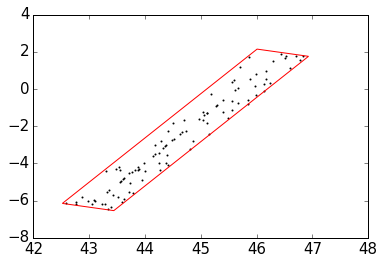

In [32]:
# Plot cherenkovs
#for crys in range(64) + range(128, 192):
for crys in range(1):
    # Get the volume hits and plot them
    vol_hits = hits.cth.filter_hits(hits.cth.get_events(hodoscope="both"), vol_id_name, values=crys)
    plt.scatter(vol_hits[x_pos_name], vol_hits[y_pos_name], s=1, transform=gca().transData._b)
    # Get the parameters
    wth, hgt, ang = test_geom.cherenkov_params
    angle = (test_geom.get_points_rhos_and_phis()[1][crys] * 180/np.pi) - ang
    a_plt = angle * np.pi/180
    # Rotate the plot correctly
    x_plt = test_geom.get_points_xs_and_ys()[0][crys] + sin(a_plt)*hgt/2. - cos(a_plt)*wth/2.
    y_plt = test_geom.get_points_xs_and_ys()[1][crys] - cos(a_plt)*hgt/2. - sin(a_plt)*wth/2. 
    # Add the rectangle
    plot_rect = plt.Rectangle((x_plt, y_plt), wth, hgt, angle=angle, color="red", fill=False)
    gca().add_artist(plot_rect)
    plt.show()

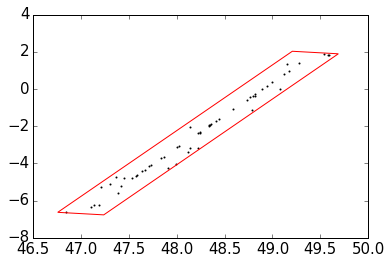

In [33]:
# Plot scintillators
#for crys in range(64,128) + range(192, 256):
for crys in range(64,65):
    # Get the volume hits and plot them
    vol_hits = hits.cth.filter_hits(hits.cth.get_events(hodoscope="both"), vol_id_name, values=crys)
    plt.scatter(vol_hits[x_pos_name], vol_hits[y_pos_name], s=1, transform=gca().transData._b)
    # Get the parameters
    wth, hgt, ang = test_geom.scintillator_params
    angle = (test_geom.get_points_rhos_and_phis()[1][crys] * 180/np.pi) - ang
    a_plt = angle * np.pi/180
    # Rotate the plot correctly
    x_plt = test_geom.get_points_xs_and_ys()[0][crys] + sin(a_plt)*hgt/2. - cos(a_plt)*wth/2.
    y_plt = test_geom.get_points_xs_and_ys()[1][crys] - cos(a_plt)*hgt/2. - sin(a_plt)*wth/2. 
    # Add the rectangle
    plot_rect = plt.Rectangle((x_plt, y_plt), wth, hgt, angle=angle, color="red", fill=False)
    gca().add_artist(plot_rect)
    plt.show()

In [34]:
def plot_add_cth_crystal(crys, geom, **kwargs):
    # Check what kind of crystal it is
    assert (crys >= 0 and crys < 256), "Volume ID {} is out of range".format(crys)
    # Check which crystal 
    if (crys < 64) or (crys >= 128 and crys < 192):
        these_params = geom.cherenkov_params
    elif (crys >= 64 and crys < 128) or (crys >= 192):
        these_params = geom.scintillator_params
    # Draw the crystal
    plot_draw_cth_crystal(crys, geom, these_params, **kwargs)

In [35]:
def plot_draw_cth_crystal(crys, geom, params, **kwargs):
    # Get the parameters
    wth, hgt, ang = params
    angle = (geom.get_points_rhos_and_phis()[1][crys] * 180/np.pi) - ang
    a_plt = angle * np.pi/180
    # Rotate the plot correctly
    x_plt = geom.get_points_xs_and_ys()[0][crys] + sin(a_plt)*hgt/2. - cos(a_plt)*wth/2.
    y_plt = geom.get_points_xs_and_ys()[1][crys] - cos(a_plt)*hgt/2. - sin(a_plt)*wth/2. 
    # Add the rectangle
    plot_rect = plt.Rectangle((x_plt, y_plt), wth, hgt, angle=angle,
                             transform=gca().transData._b, **kwargs)
    gca().add_artist(plot_rect)

In [36]:
def plot_add_cth_outlines(geom, **kwargs):
    # Loop through and draw all crystals
    for crystal in range(256):
        plot_add_cth_crystal(crystal, geom, fill=False, alpha=0.2, lw=0.4, **kwargs)

In [37]:
def plot_add_cth(output, geom, **kwargs):
    # Get the signal crystals
    sig_crystals = [i for i, e in enumerate(output) if e == 1]
    bkg_crystals = [i for i, e in enumerate(output) if e == 2]
    # Loop through and draw all crystals
    for crystal in sig_crystals:
        plot_add_cth_crystal(crystal, geom, alpha=0.5, \
                             lw=0.4, color="Blue", **kwargs)
    for crystal in bkg_crystals:
        plot_add_cth_crystal(crystal, geom, alpha=0.5, \
                             lw=0.4, color="Red", **kwargs)

# CDC Alignment

In [38]:
hits.cydet.geom.phi0_by_layer = [phi_0 + np.pi for phi_0 in hits.cydet.geom.phi0_by_layer]

In [39]:
print hits.cydet.geom.phi0_by_layer

[6.2990523071795863, 6.2985853071795859, 6.2831853071795862, 6.2977293071795861, 6.2831853071795862, 6.2831853071795862, 6.2966113071795862, 6.2831853071795862, 6.2959563071795861, 6.2831853071795862, 6.2953623071795857, 6.2831853071795862, 6.2948213071795864, 6.2831853071795862, 6.2831853071795862, 6.2831853071795862, 6.293871307179586, 6.2831853071795862]


In [40]:
cydet_vol_id_name = "CDCHit.fvol_id"
cydet_z_pos_name = "CDCHit.fMCPos.fP.fX"
cydet_x_pos_name = "CDCHit.fMCPos.fP.fZ"
cydet_y_pos_name = "CDCHit.fMCPos.fP.fY"
cydet_t_pos_name = "CDCHit.fMCPos.fE"
hits.cydet.data[cydet_x_pos_name] = - (hits.cydet.data[cydet_x_pos_name]/10. - 765)
hits.cydet.data[cydet_y_pos_name] = hits.cydet.data[cydet_y_pos_name]/10.
hits.cydet.data[cydet_z_pos_name] = (hits.cydet.data[cydet_z_pos_name]/10. - 641)

In [41]:
coordinate_file = file_base + "sense_wire_positions.txt"

In [42]:
wire_to_coords = np.ndarray((hits.cydet.geom.n_points*2,2,3))

In [43]:
with open(coordinate_file) as coords:
    for line in coords.readlines():
        split_line = line[:-1].split(" ")
        wire = int(split_line[0].split("_")[-2])
        all_coords = np.array(split_line[1:7], dtype=float).reshape(2,-1)
        wire_to_coords[wire] = all_coords

In [44]:
x_pos, y_pos = hits.cydet.geom.get_points_xs_and_ys()

In [45]:
wire_to_coords[0:198*2:2,1,:2] - np.array([x_pos[:198], y_pos[:198]]).T

array([[  3.69439453e-04,   1.61964647e-04],
       [  2.50647963e-04,   1.61913640e-04],
       [  6.71712791e-05,   1.58060427e-04],
       [  9.25927162e-04,   1.64044846e-04],
       [ -1.28426448e-05,   1.61746013e-04],
       [  4.64266234e-04,   1.58972044e-04],
       [  6.23605927e-04,   1.21143815e-04],
       [  7.84208121e-04,   1.62971046e-04],
       [  3.17462826e-04,   1.80119047e-04],
       [  6.46744412e-04,   1.40864413e-04],
       [  2.46985311e-04,   1.27738039e-04],
       [  6.44197799e-04,   1.39153773e-04],
       [  4.14944344e-04,   1.91021074e-04],
       [  1.85757062e-04,   1.18340059e-04],
       [  6.32506846e-04,   1.76777328e-04],
       [  4.79722824e-04,   1.44220971e-04],
       [  4.99862823e-04,   1.22313211e-04],
       [  5.12535562e-04,   1.37959120e-04],
       [  3.83675383e-04,   1.44809903e-04],
       [  2.46703224e-05,   1.24719246e-04],
       [  3.91444425e-04,   1.89171272e-04],
       [  4.83495208e-04,   1.80678657e-04],
       [  

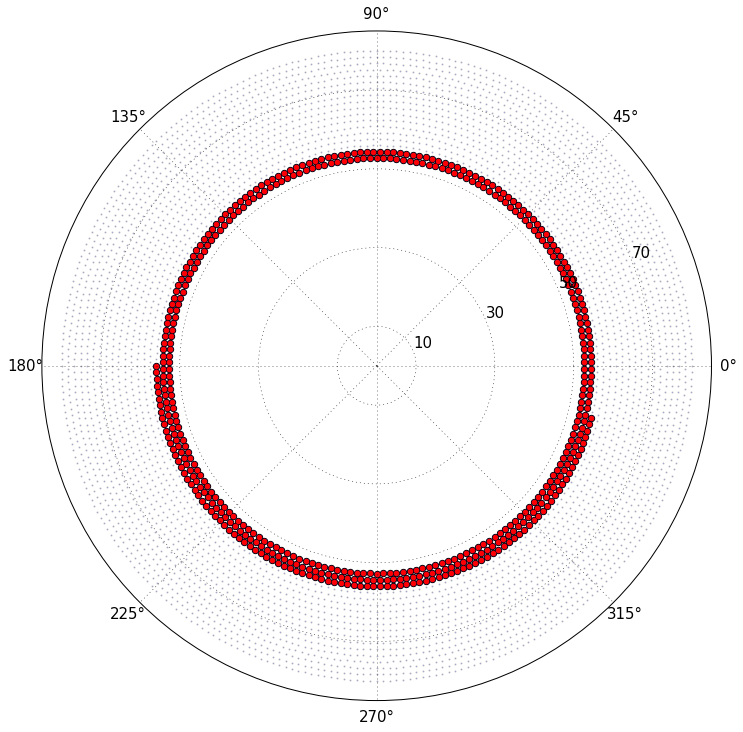

In [47]:
start = 0
stop = 500
evt = 10
plot_output(np.zeros_like(hits.cydet.get_hit_types(evt)), geom)
plt.scatter(wire_to_coords[start*2:stop*2:2,1,0], 
            wire_to_coords[start*2:stop*2:2,1,1],
            s=40,
            transform=gca().transData._b)
plt.scatter(x_pos[start:stop], 
            y_pos[start:stop],
            transform=gca().transData._b,
           color="Red")

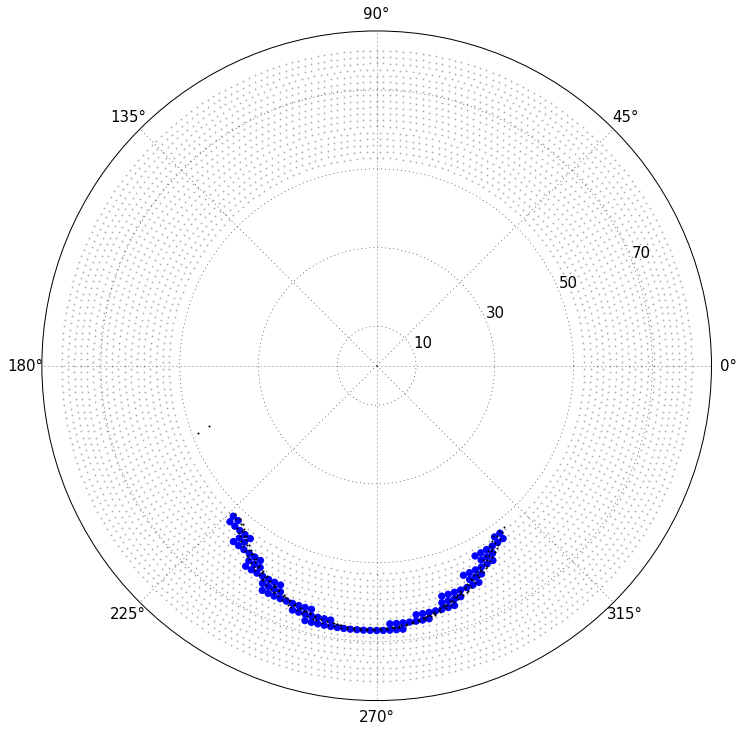

In [48]:
evt = 5
#plot_output(np.zeros_like(hits.cydet.get_hit_types(evt)), geom)
plot_output(hits.cydet.get_hit_types(evt), geom)
hits.cydet.sort_hits(cydet_t_pos_name)
cdc_hits = hits.cydet.get_signal_hits(evt)
cth_hits = hits.cth.get_events(evt)
plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, transform=gca().transData._b)    
plt.scatter(cdc_hits[cydet_x_pos_name], cdc_hits[cydet_y_pos_name], s=1, transform=gca().transData._b)
plt.show()

## Plot Both

In [61]:
max_z = np.amax(hits.cydet.get_signal_hits()[cydet_z_pos_name])
min_z = np.amin(hits.cydet.get_signal_hits()[cydet_z_pos_name])

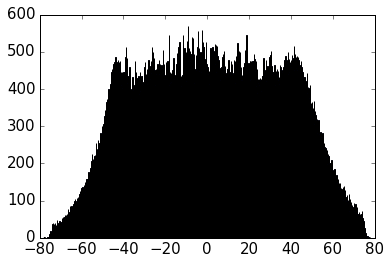

In [67]:
plt.hist(hits.cydet.get_signal_hits()[cydet_z_pos_name], bins=1000)
plt.show()

0.573591588294 0.812492736681
[ 56  57  58  59 122 123 124]


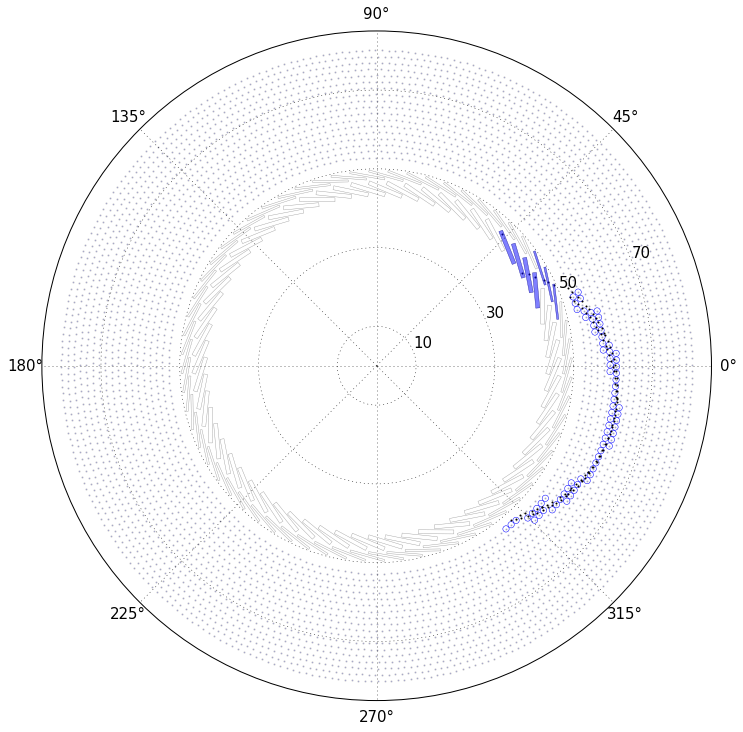

0.208493595595 0.389303881203
[173 174 236 237]


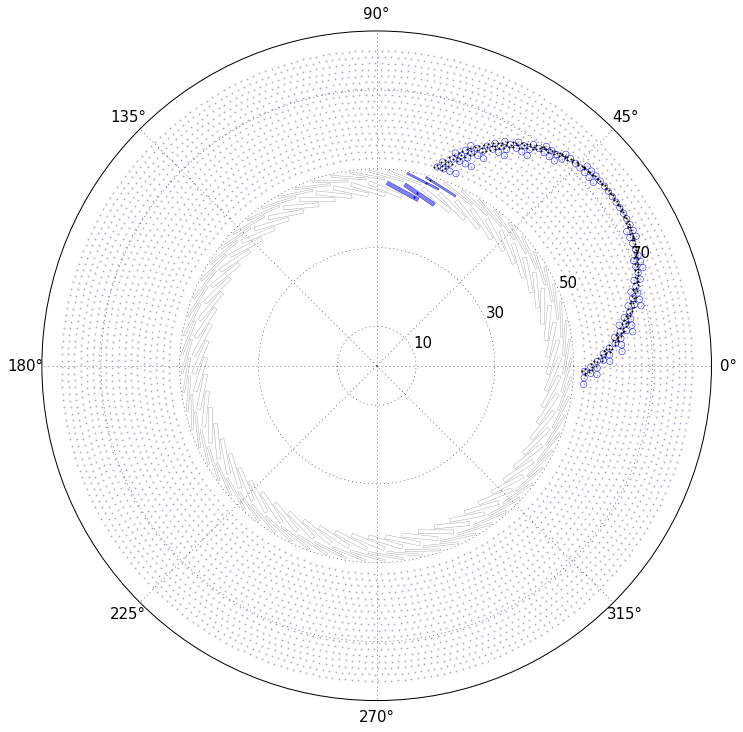

0.651021754624 0.890165056979
[ 39  40 103 104]


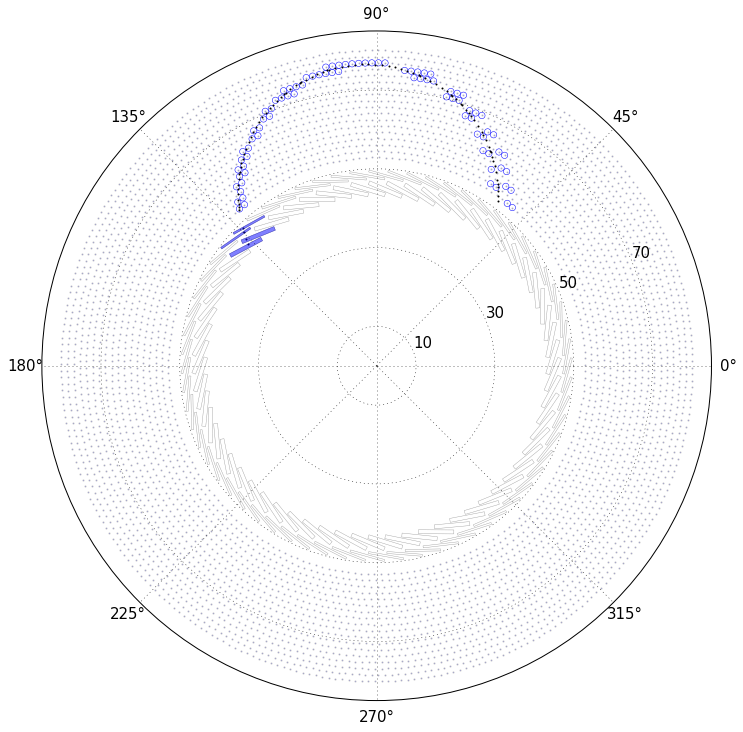

0.450292592367 0.646789479409
[31]


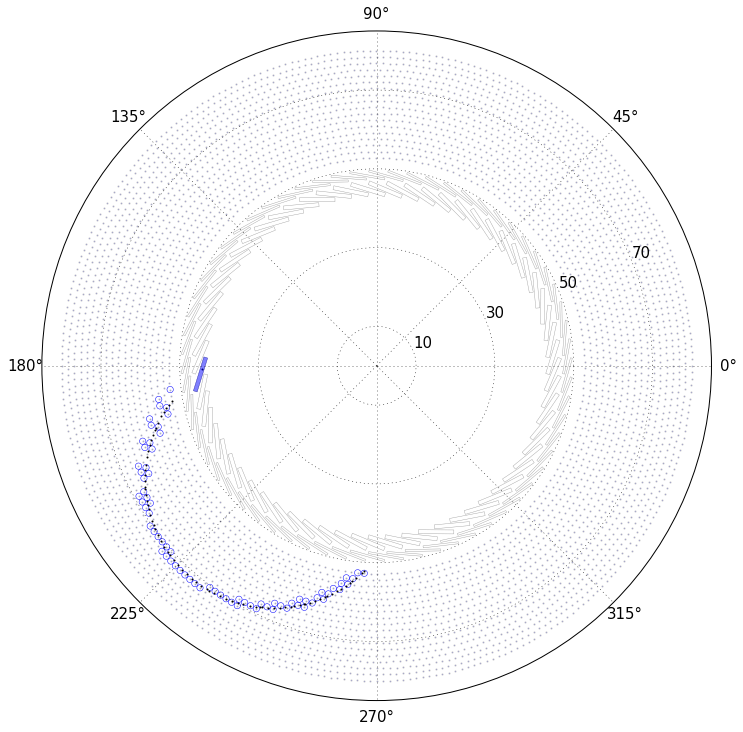

0.202470910713 0.629654089034
[145 190 191 208 253 254]


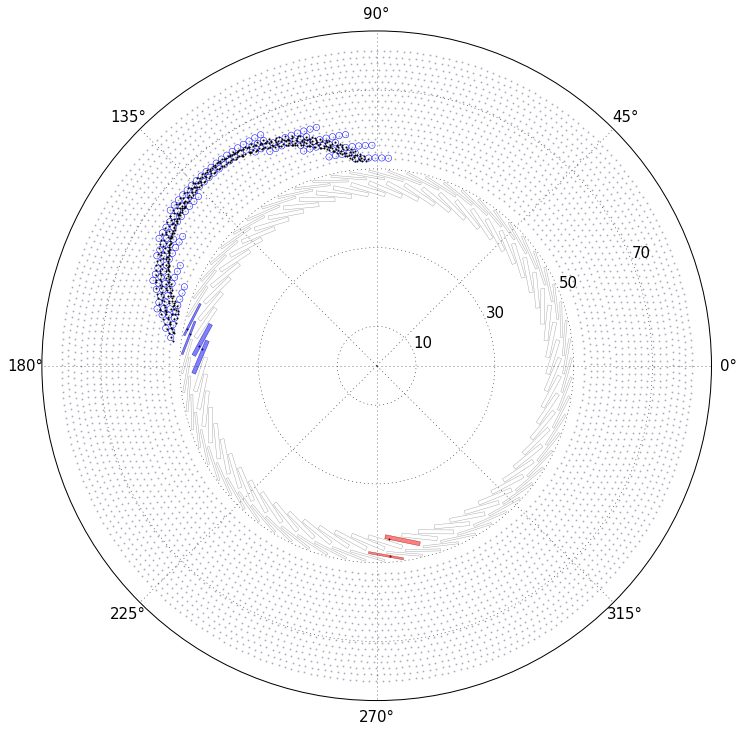

0.304822449918 0.734585972205
[28 92]


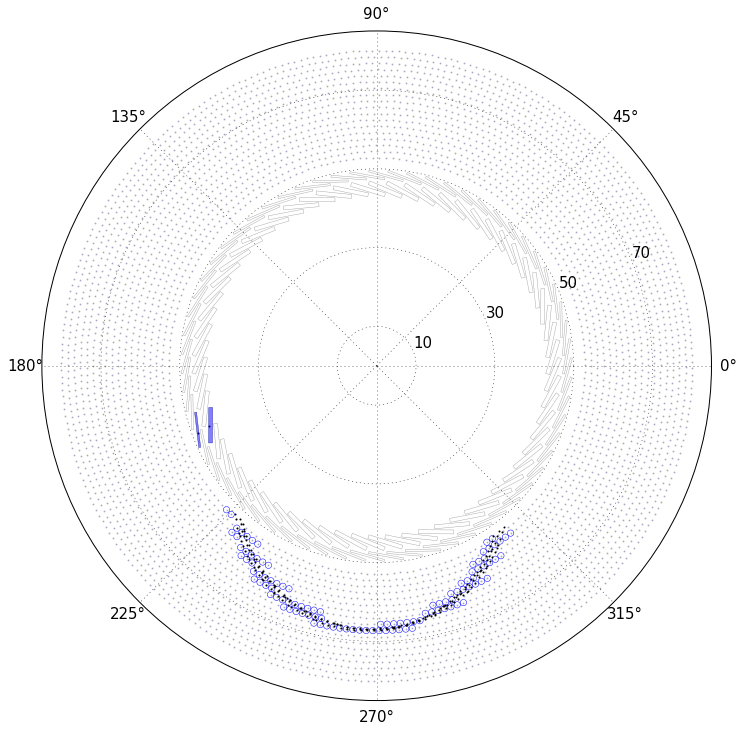

0.102847322972 0.412314454295
[140 152 185 186 187 234 235 249 250]


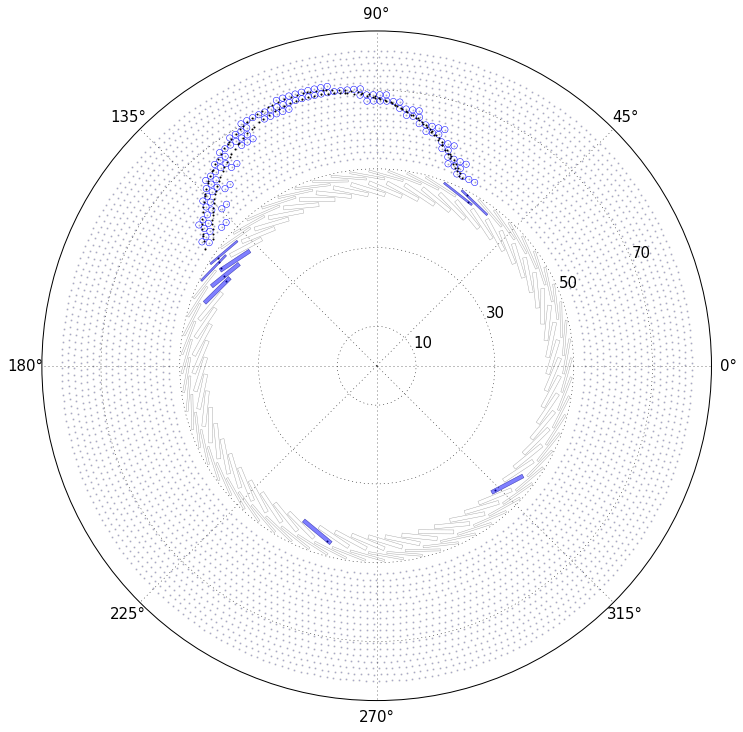

0.114603120825 0.280193199655
[128 191 192 255]


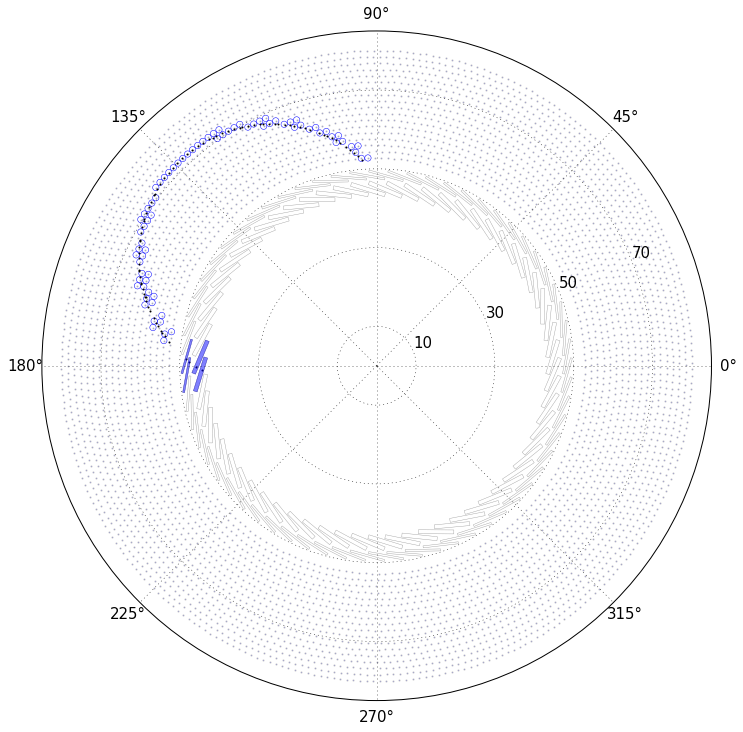

0.642429754455 0.920894122987
[ 21  22  45  46  47 109 110 111]


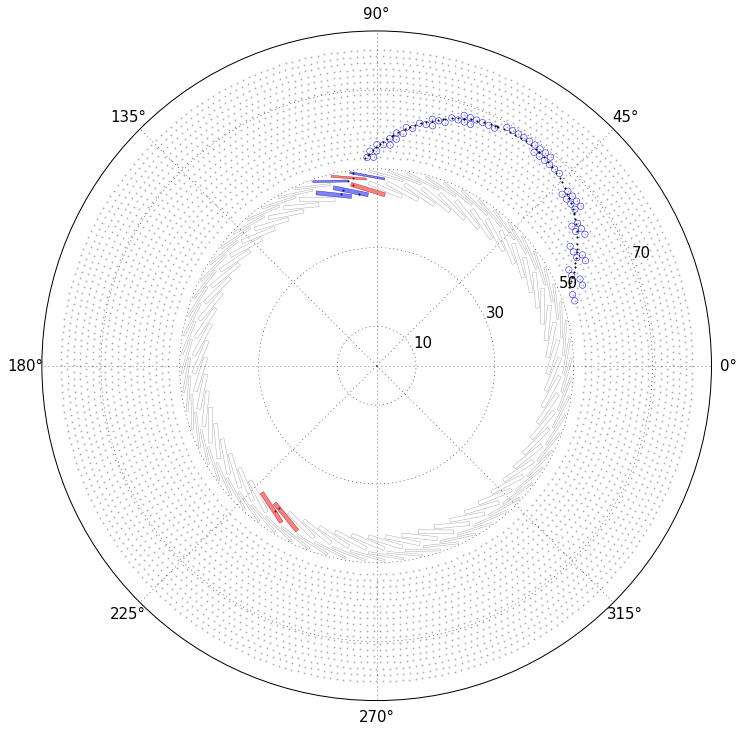

0.622746524192 0.873372159419
[ 37  38  39 102 103]


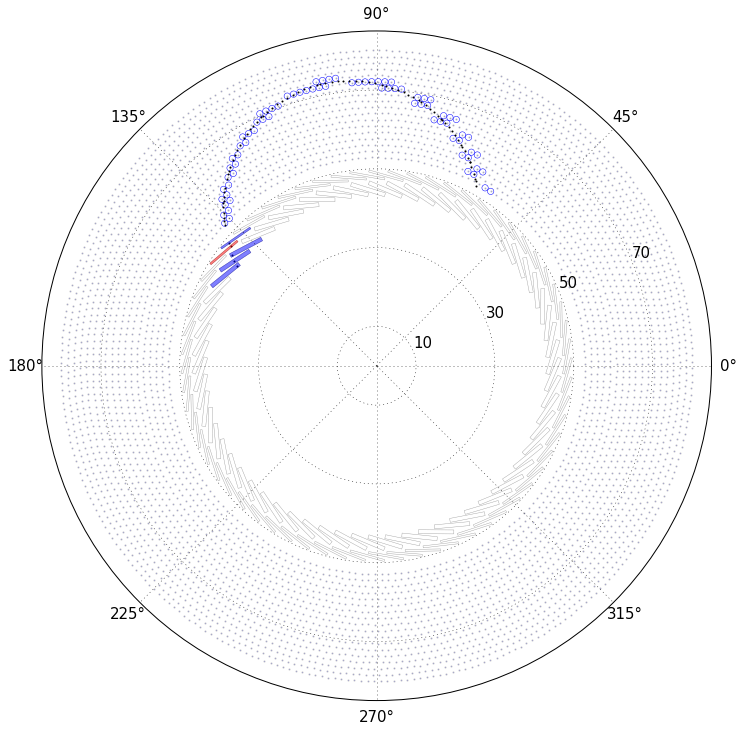

In [71]:
for evt in range(10):
    cdc_hits = hits.cydet.get_signal_hits(evt)
    max_project = (np.amax(cdc_hits[cydet_z_pos_name]) - min_z)/(max_z - min_z)
    min_project = (np.amin(cdc_hits[cydet_z_pos_name]) - min_z)/(max_z - min_z)
    print min_project, max_project
    geom = CyDet(projection=max_project)
    hits.cydet.get_hit_types(evt)
    plot_output(np.zeros_like(hits.cydet.get_hit_types(evt)), geom)
    plot_add_outlines(hits.cydet.get_hit_types(evt), geom)
    plot_add_cth(hits.cth.get_vol_types(evt), hits.cth.geom)
    print hits.cth.get_hit_vols(evt)
    plot_add_cth_outlines(hits.cth.geom)
    cth_hits = hits.cth.get_events(evt)
    plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, transform=gca().transData._b)
    plt.scatter(cdc_hits[cydet_x_pos_name], cdc_hits[cydet_y_pos_name], s=1, transform=gca().transData._b)
    plt.show()